###__Machine learning tri-training pipeline for phenotype labeling in procaryotes from the protein domains in their genome__

####__Package and environment setup__

#####__Mount to Google Drive__

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#####__Import required packages__

In [2]:
# importing package utilities
import json
import logging
import os
import warnings
import random
import subprocess
import pickle
import joblib
import time
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO
from math import sqrt
from copy import deepcopy
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


# sklearn packages
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier

from sklearn.model_selection import permutation_test_score
from sklearn.cross_decomposition import PLSRegression
from keras.utils import to_categorical
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report
from sklearn.metrics import make_scorer, confusion_matrix, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD

# packages for imbalance pipeline
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
#from imblearn.pipeline import Pipeline as imbPipeline

# other packages
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
import nltk
from nltk import sent_tokenize, word_tokenize
from scipy import spatial
from scipy.stats import randint
from scipy.special import softmax
from scipy.stats import chisquare


from gensim.models import KeyedVectors
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

#####__Changing directory to data path__

In [3]:
os.chdir("/content/drive/My Drive/Notebooks")

#####__Basic configuration for figures and logging__

In [4]:
warnings.filterwarnings("ignore")
# sys.path.append("/content/drive/My Drive/Notebooks")
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
#plt.style.use('ggplot')

####__Data loading and preprocessing__

######__Parse phenotype data__

In [5]:
def parse_phenotype_data(phenotype_file, delimiter):
  """Parse a line in a genome record to extract the useful information.
  
    :param phenotype_file: String, name of the file containing phenotypes.
    :param delimiter: String, the separator of the entries of the line.

    :return: Dict, containing genome ID as key and string phenotype as
                    value.
  """
  phenotype_data = {}
  with open(phenotype_file) as temp_file:
    for line in temp_file:
      if not line.strip():
        continue
      line = line.strip()
      if line.startswith("GCA"):
        try:
          sample, phenotype = line.split(delimiter)
          phenotype_data[sample] = phenotype
        except:
          print("This line has more that two elements")
          print(line)
          pass
    return phenotype_data

######__Merge phenotype and genome data__

In [6]:
def merge_phenotype_genomic(chunk_genomic, phenotype, path, keyword,
                            statistics=True, version=0):
  """Merge genome records with phenotype data.
  
    :param chunk_genomic: Dataframe, pandas dataframe where 
                          genome data is loaded by chunk.
    :param phenotype: Dict, contains the genome ID as key 
                      and phenotype as value.
    :param path: String, name of an existing directory, 
                  to write the file to.
    :param keyword: String, name indicating the trait of phenotype.
    :param statistics: Boolean, get and print descriptive statistics.
                                Default is True
    :param version: int, number to indicate the version of 
                    unlabeled data. Default is 0

    :return: Tuple, containing dictionary {number_ID: phenotype},
                    dictionary {phenotype: number_ID}, 
                    pandas.Serie of labeled data length,
                    pandas.Serie of unlabeled data length
                    maximum length of genome and 
                    the merged dataframe of phenotype and genomes
  """
  chunk_list, i = [], 1

  for chunk in chunk_genomic:
    logging.info("Working with chunk {0}".format(i))
    chunk_list.append(chunk)
    i += 1
  
  # concatenate chunks of data
  df_concat = pd.concat(chunk_list)

  # merge phenotype and genotype data
  df_concat = pd.merge(df_concat, phenotype, left_on="contig", how='left',
                         right_index=True)
  df_concat["length"] = df_concat[" domain"].apply(lambda num: len(num.split()))

  # create a new column 'phenotype_id' with encoded phenotypes
  df_concat["phenotype_id"] = df_concat["phenotype"].factorize()[0]
  phenotype_id_df = df_concat[['phenotype', 'phenotype_id']].drop_duplicates()
  phenotype_id_df = phenotype_id_df.dropna(axis=0)

  # dictionaries  of 'phenotype_id' with encoded phenotypes for future use
  phenotype_to_id = dict(phenotype_id_df.values)
  id_to_phenotype = dict(phenotype_id_df[['phenotype_id', 'phenotype']].values)
  id_pheno_df = pd.DataFrame.from_dict(id_to_phenotype, orient='index',
                                     columns=["label"])
  id_pheno_df.to_csv("id_label_phenotype.csv")

  # get max sequence length
  max_len = df_concat["length"].max()

  # retrieve label and unlabelled data
  labeled_data = df_concat[pd.notna(df_concat["phenotype"])]
  unlabeled_data = df_concat.drop(labeled_data.index)

  # get count by class 
  class_count = labeled_data[["contig", "phenotype"]].groupby(["phenotype"])["contig"]\
  .count()\
  .reset_index(name='count') \
  .sort_values(['count'], ascending=False)
  class_count.to_csv(f"{keyword}_count.csv", index=False)

  # retrieve length for label and unlabelled data
  len_labeled, len_unlabeled = labeled_data["length"], unlabeled_data["length"]

  # drop length column from labelled and unlabelled data
  labeled_data = labeled_data.drop(["length", "phenotype"], axis=1)
  unlabeled_data = unlabeled_data.drop(["length", "phenotype"], axis=1)

  logging.info("Writing labeled and unlabeled data into separate CSV files")

  if not os.path.exists(path):
    os.makedirs(path)
  elif os.path.exists(path) and os.path.exists(f"{path}/labeled_data.csv"):
    os.remove(f"{path}/labeled_data.csv")
  if os.path.exists(path) and os.path.exists(f"{path}a/unlabeled_data_{version}.csv"):
    os.remove(f"{path}/unlabeled_data_{version}.csv")

  labeled_data.to_csv(f"{path}/labeled_data.csv", index=False)
  unlabeled_data.to_csv(f"{path}/unlabeled_data_{version}.csv", index=False)

  # remove NAN from dataframe
  df_concat = df_concat.dropna(axis=0).drop(["length", "phenotype"], axis=1)

  if statistics:
    logging.info("Getting descriptive statistics for data...")
    num_genome =  labeled_data.shape[0]
    train_size = num_genome * 0.8
    test_size = num_genome - train_size
    num_classes = len(labeled_data["phenotype_id"].unique())
    max_len_ = len_labeled.max()
    min_len = len_labeled.min()
    avg_len = len_labeled.mean()
    std_len = len_labeled.std()
    
    lab_tokenizer = Tokenizer(filters="!#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n")
    lab_tokenizer.fit_on_texts(labeled_data[" domain"])
    vocab_l = lab_tokenizer.word_index
    vocab_lab = len(vocab_l)
    print("********** Descriptive statistics of labeled data ***********")
    print(f"Number of genomes:   {num_genome}")
    print(f"Training size:   {train_size}")
    print(f"Test size:   {test_size}")
    print(f"Number of classes:   {num_classes}")
    print(f"Maximum genome length:  {max_len_}")
    print(f"Minimum genome length:  {min_len}")
    print(f"Average genome length:  {avg_len}")
    print(f"Standard error:   {std_len}")
    print(f"Vocabulary size:   {vocab_lab}")

    print("\n********** Descriptive statistics of unlabellabeled data ***********")
    num_genome =  unlabeled_data.shape[0]
    max_len_ = len_unlabeled.max()
    min_len = len_unlabeled.min()
    avg_len = len_unlabeled.mean()
    std_len = len_unlabeled.std()
    lab_tokenizer = Tokenizer(filters="!#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n")
    lab_tokenizer.fit_on_texts(unlabeled_data[" domain"])
    vocab_u = lab_tokenizer.word_index
    vocab_lab = len(vocab_u)
    print(f"Number of genomes:   {num_genome}")
    print(f"Maximum genome length:  {max_len_}")
    print(f"Minimum genome length:  {min_len}")
    print(f"Average genome length:  {avg_len}")
    print(f"Standard error:   {std_len}")
    print(f"Vocabulary size:   {vocab_lab}")
    intersec = set(vocab_l).intersection(set(vocab_u))
    print(f"Intersection of vocabularies of labeled and unlabeled data: {len(intersec)}")
  return id_to_phenotype, phenotype_to_id, len_labeled, len_unlabeled, max_len, df_concat

######__Remove classes with low frequency__

In [7]:
def remove_classes_with_low_freq(data_frame, min_freq):
  """Remove phenotype classes with low frequency.
  
    :param data_frame: Dataframe, merged data phenotype and genomes.
    :param min_freq: int, indicate the minimum frequency

    :return: Dataframe, containing data of phenotype classes with
                higher frequency.
  """
  classes, under_rep = data_frame["phenotype_id"].unique(), []
  for phenotype in classes:
    cl_freq = np.count_nonzero(data_frame["phenotype_id"].values == phenotype)
    if cl_freq <= min_freq:
      under_rep.append(phenotype)
  rep_classes = list(set(classes) - set(under_rep))
  logging.info(f"Classes {', '.join(str(x) for x in under_rep)} were removed")
  logging.info(f"{len(rep_classes)} classes were kept")
  return data_frame[data_frame["phenotype_id"].isin(rep_classes)]

######__Load data__

Load initial genome and phenotype data

In [8]:
def get_initial_data(genome_file, pheno_file, path, delimiter=",", chunksize=10000,
                     pheno_col="phenotype", statistics=True, min_freq=10):
  """Parse, merge data and remove infrequent classes.

    :param genome_file: String, name of the file containing genomes.
    :param phenotype_file: String, name of the file containing phenotypes.
    :param path: String, name of an existing directory, 
                  to write the file to.
    :param delimiter: String, the separator of the entries of the line.
                      Default is comma ","
    :param chunksize: int, indicate the number of genomes data per 
                      chunk in dataframe Default is 10000.
    :param pheno_col: String, name of the column containing phenotype data.
    :param statistics: Boolean, get and print descriptive statistics.
                                Default is True
    :param min_freq: int, indicate the minimum frequency. Default is 10.

    :return: Tuple, containing dataframe of the labeled data,
                    dictionary {number_ID: phenotype},
                    dictionary {phenotype: number_ID}, 
                    pandas.Serie of labeled data length,
                    pandas.Serie of unlabeled data length
                    maximum length of genome and 
  """
  
  keyword = pheno_file.split(".")[0]
  logging.info("Parsing phenotype data...")
  pheno = parse_phenotype_data(pheno_file, delimiter)
  pheno = pd.DataFrame.from_dict(pheno, orient="index", columns=[pheno_col])
  
  logging.info("Loading genomic data...")
  genomic_data = pd.read_csv(genome_file, chunksize=chunksize)

  logging.info("Merging phenotype and genomic data...")
  id_to_phenotype, phenotype_to_id, len_labeled, len_unlabeled, \
  max_len, data_frame = merge_phenotype_genomic(genomic_data, pheno,
                                                path, keyword, statistics)
  
  logging.info(f"Removing lower frequency lower, min_freq={min_freq}...")
  data_frame = remove_classes_with_low_freq(data_frame, min_freq)
  return data_frame, id_to_phenotype, phenotype_to_id, len_labeled, len_unlabeled, max_len

Load dataframe of genome and phenotype after one iteration

In [9]:
def get_existing_data(data_file):
  """Parse a line in a genome record to extract the useful information.
  
    :param data_file: String, name of the file containing the data.

    :return: Dict, containing genome ID as key and string phenotype as
                    value.
  """
  chunk_list, i = [], 1
  data = pd.read_csv(data_file, chunksize=5000)
  for chunk in data:
    logging.info("Loading chunk {0} ...".format(i))
    chunk_list.append(chunk)
    i += 1
  data = pd.concat(chunk_list)
  return data


######__Compute sample and class weight__

In [10]:
def compute_class_weights(labeled_data):
  """Compute class weights.
  
    :param labeled_data: Dataframe, containing labeled data.

    :return: Dict, containing class ID as key and float class weight as value.
  """
  count_per_class = labeled_data.groupby("phenotype_id").count()["contig"]
  total_samples = count_per_class.sum()
  percent_per_class = count_per_class.apply(lambda x: x * 100 / total_samples)
  minor_count = percent_per_class.min()
  class_weights =  percent_per_class.apply(lambda x: minor_count / x )
  return class_weights.to_dict()


def get_array_of_class_weight_per_sample(class_weights, y_train):
  """Compute sample weights.
  
    :param class_weights: Dict, containing class ID as key and float
                          class weight as value.
    :param y_train: List of numpy array, containing labels of training data.

    :return: numpy array, containing sample weights.
  """
  weight_array = np.ones_like(y_train, dtype =float)
  for i, val in enumerate(y_train):
    weight_array[i] = class_weights[val]
  return weight_array

####__Evaluate machine learning techniques with cross validation__

######__Get the dictionary of models to be evaluated__

In [11]:
def get_models_to_be_evaluated(class_weights="balanced"):
  models = {}
  models["DUMMY"] = DummyClassifier(strategy="most_frequent", random_state=26)
  models["SVC"] = SVC(C=2, gamma='scale', class_weight="balanced", random_state=26)
  models["KNN"] = KNeighborsClassifier(weights="distance")
  models["DTree"] = DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=26)
  models["LOG"] = LogisticRegression(solver='lbfgs', class_weight="balanced", C=4, random_state=26)
  models["SGD"] = SGDClassifier(loss="hinge", penalty="l2", alpha=1e-3,
                                learning_rate="optimal", eta0=0.001,
                                random_state=26, tol=1e-3, class_weight="balanced")
  models["LSVC"] = LinearSVC(loss="hinge", C=0.1, random_state=26, class_weight="balanced", max_iter=10000, tol=1e-4)
  models["RF"] = RandomForestClassifier(n_estimators=1000, max_depth=5,
                                        class_weight="balanced", random_state=26)
  models["MNB"] = MultinomialNB()

  #models["BAG"] = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
  #                                  n_estimators=1000, random_state=26)
  models["ET"] = ExtraTreesClassifier(n_estimators=1000, max_depth=5,
                                      class_weight="balanced",random_state=26)
  #models["ADB"] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
  #                                   random_state=26, learning_rate=0.36,
  #                                   n_estimators=200)
  return models

######__Evaluate models__

In [12]:
def evaluate_models(features, labels, models,
                    scoring={"accuracy" : make_scorer(accuracy_score),
                             "f1_score" : make_scorer(f1_score, average = "micro")},
                    n_splits=5, n_repeats=3, random_state=26, save=False):
  
  assert type(models) == dict, f"models should be dict but {type(models)} found"
  assert type(scoring) == dict, f"models should be dict but {type(scoring)} found"
  
  entries, dataframes, cv_data = [], [], None
  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats,
                              random_state=random_state)
  for model in models:
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_df=0.8, norm='l2')
    start = time.time()
    model_name = models[model].__class__.__name__
    logging.info(f"Performing cross-validation for {model_name}...")
    pipeline = Pipeline([('tfidf_vec', tfidf_vectorizer),
                         ('classifier', OneVsRestClassifier(models[model]))])
    scores = cross_validate(pipeline,features, labels, scoring=scoring, cv=cv, 
                            n_jobs=-1)
    cv_data = pd.DataFrame.from_dict(scores)
    cv_data["model_name"] = [model] * cv_data.shape[0]
    dataframes.append(cv_data)
    logging.info(f"Time is for {model_name}: {round(time.time() - start, 3)}")
  final_data = pd.concat(dataframes, ignore_index=True)
  final_data["time"] = final_data.score_time + final_data.fit_time
  final_data = final_data.drop(["score_time", "fit_time"], axis=1)
  if save:
    final_data.to_csv("cross_val_scoring.csv", index=False)
  return final_data

This cell define a fully connected neural network with one hidden layer of 100 units/neurons

In [13]:
def nn_model(in_shape, num_classes, hidden_ac, hidden_units=100):
  model = Sequential()
  model.add(Dense(hidden_units, input_shape=in_shape, activation=hidden_ac))
  opt = SGD(lr=0.01, momentum=0.9)
  if num_classes == 2 :
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [14]:
def cross_val_pls_lgb_ann(models, features,labels, n_comp, n_splits, n_repeats, state):
  cv = RepeatedStratifiedKFold(n_splits, n_repeats,random_state=state)
  pls_score, pls_frame = [], pd.DataFrame()
  lgb_score, lgb_frame = [], pd.DataFrame()
  ann_score, ann_frame = [], pd.DataFrame()
  cv_frame, i = None, 1
  n_classes = len(np.unique(labels))
  
  for train_index,test_index in cv.split(features,labels):
    logging.info(f"--------Performing {i}th cross validation...")
    x_train,x_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    for mod in models:
      if mod == "PLS":
        logging.info(f"Performing PLS-DA...")
        mod = PLSRegression(n_comp)
        mod.fit(x_train,y_train_cat)
        score = accuracy_score(y_test, np.argmax(mod.predict(x_test), axis=1))
        pls_score.append(score)

      elif mod == "LGB":
        logging.info(f"Performing LightGBM...")
        sample_weights = get_array_of_class_weight_per_sample(class_weights,
                                                              y_train)
        mod = fit_lightgbm_model(x_train, y_train, n_classes,
                             params=params_gbm, weight=sample_weights)
        score = accuracy_score(y_test, np.argmax(mod.predict(x_test), axis=1))
        lgb_score.append(score)    
    
      else:
        logging.info(f"Performing Neural Network...")
        es = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=3)
        mc = ModelCheckpoint('best_model.h5', monitor='val_loss',
                             mode='min', verbose=0, save_best_only=True)
        mod = nn_model((x_train.shape[1],), n_classes, "relu", hidden_units=100)
        if n_classes == 2:
          mod.fit(x_train, y_train, epochs=10000, batch_size=100, 
          validation_data=(x_test, y_test), verbose=0, callbacks=[es, mc])
          score = accuracy_score(y_test, np.round(mod.predict(x_test)))
          ann_score.append(score)
        else:
          mod.fit(x_train, y_train_cat, epochs=10000, batch_size=100, 
          validation_data=(x_test, y_test_cat), verbose=0, callbacks=[es, mc])
          score = accuracy_score(y_test, mod.predict_classes(x_test))
          ann_score.append(score)
    i+=1
  pls_frame["model_name"] = ["PLS" for i in range(len(pls_score))]
  pls_frame["test_f1_score"] = pls_score
  lgb_frame["model_name"] = ["LGB" for i in range(len(lgb_score))]
  lgb_frame["test_f1_score"] = lgb_score
  ann_frame["model_name"] = ["ANN" for i in range(len(ann_score))]
  ann_frame["test_f1_score"] = ann_score
  cv_frame = pls_frame.append(lgb_frame)
  cv_frame = cv_frame.append(ann_frame)
  mean_accuracy = cv_frame.groupby('model_name').mean()
  std_accuracy = cv_frame.groupby('model_name').std()
  return cv_frame, pd.concat([mean_accuracy, std_accuracy], axis= 1)

######__Average metrics for model performance__

In [15]:
def average_metrics_per_model(cv_data, save=False):
  mean_accuracy = cv_data.groupby('model_name').mean()
  columns_l = [f"Avg_{i}" for i in list(mean_accuracy.columns)]
  mean_accuracy.columns = columns_l
  std_accuracy = cv_data.groupby('model_name').std()
  columns_l = [f"Std_{i}" for i in list(std_accuracy.columns)]
  std_accuracy.columns = columns_l
  acc = pd.concat([mean_accuracy, std_accuracy], axis= 1)
  if save:
    acc.to_csv("avg_cross_val_scoring.csv", index=False)
  return acc

####__Tri-training pipeline with Logistic Regression, ExtraTreeClassifier and LightGBM__

######__Fit and save the predictions models to file__

Logistic Regression

In [16]:
def fit_and_save_logistic_reg(x_training, y_training, params,
                              one_vs_rest=True, save=False, 
                              save_as="logistic_reg.joblib"):
  if one_vs_rest:
    model_fit = OneVsRestClassifier(LogisticRegression(**params))
  else:
    model_fit = LogisticRegression(**params)
  model_fit.fit(x_training, y_training)

  if save and not os.path.exists(save_as):
    joblib.dump(model_fit, save_as)
  
  return model_fit

LigthGBM

In [17]:
def fit_lightgbm_model(x_training, y_training, num_class,
                       params, weight=None,
                       save_as="good_LGB.model", 
                       save=False, epochs=50):
  
  params["num_class"] = num_class
  dtrain = lgb.Dataset(x_training, label=y_training, weight=weight)
  booster_trained = lgb.train(params, dtrain)

  if save and not os.path.exists(save_as):
    booster_trained.save_model(save_as)
    
  return booster_trained

Extra Tree Classifier

In [18]:
def fit_and_save_extra(x_training, y_training, params,
                     one_vs_rest=True, save=False,
                     save_as="extra.joblib"):
  if one_vs_rest:
    model_fit = OneVsRestClassifier(ExtraTreesClassifier(**params))
  else:
    model_fit = ExtraTreesClassifier(**params)
  model_fit.fit(x_training, y_training)

  if save and not os.path.exists(save_as):
    joblib.dump(model_fit, save_as)
    
  return model_fit

Support Vector Machine

In [19]:
def fit_and_save_svm(x_training, y_training, params,
                     one_vs_rest=True, save=False,
                     save_as="svm.joblib"):
  if one_vs_rest:
    model_fit = OneVsRestClassifier(LinearSVC(**params))
  else:
    model_fit = LinearSVC(**params)
  model_fit.fit(x_training, y_training)
  if save and not os.path.exists(save_as):
    joblib.dump(model_fit, save_as)
  return model_fit

XGBoost

In [20]:
def fit_xgboost_model(x_training, y_training, num_class, params,
                      weight=None, save_as="xgboost_optimal2.model", 
                      save=False):
  
  params["num_class"] = num_class
  dtrain = xgb.DMatrix(data=x_training, label=y_training, weight=weight)
  booster_trained = xgb.train(params, dtrain)

  if save and not os.path.exists(save_as):
    booster_trained.save_model(save_as)

  return booster_trained

# Voting with decision (voting) function
  #svm_prob = np.array(svm_model.decision_function(xtest))
  # softmax for getting the probabilities after the voting
  #svm_prob = np.exp(svm_prob)/(np.sum(np.exp(svm_prob),axis=1).reshape(-1, 1))
#  mod2 = np.array(svm_model.decision_function(xtest))
#   mod2 = np.exp(mod2)/(np.sum(np.exp(mod2),axis=1).reshape(-1, 1))

######__Plot metrics for fitted model to evaluate model performance__

In [21]:
def print_stats(preds, target, labels, sep='-', sep_len=80, fig_size=[6, 5],
                normalized=True, cmap='bone'):
  print('Accuracy = %.3f' % accuracy_score(target, preds))
  print(sep*sep_len)
  print('Classification report:')
  print(classification_report(target, preds))
  print(sep*sep_len)
  print('Confusion matrix')
  cm=confusion_matrix(target, preds)
  plt.figure(figsize=fig_size)
  norm_cm = cm
  if normalized:
    cm = cm / np.sum(cm, axis=1)[:,None]
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=labels, yticklabels=labels, cmap=cmap)
  plt.pause(0.05)
# print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

######__Utility function for labelling data__

Get pseudo label from the consensus of the three classifiers predictions

In [22]:
def predict_pseudo_label(pred_log, pred_xgb, pred_et, threshold=0.5):

  assert len(pred_log) == len(pred_xgb) == len(pred_et),\
  "The three numpy array must have the same length"
  num_class = len(pred_log) - 1

  assert pred_log.ndim == pred_xgb.ndim == pred_et.ndim == 1,\
  "Only 1D numpy array is accepted"

  class_label = None
  preds = [pred_log, pred_xgb, pred_et]
  preds_max = [np.argmax(x) for x in preds]
  label_counts = Counter(preds_max)

  for label, lab_count in label_counts.items():
    if lab_count == 3 or lab_count == 2 :
      log = pred_log[preds_max[0]]
      xgb = pred_xgb[preds_max[1]]
      svm = pred_et[preds_max[2]]

      if log >= threshold or xgb >= threshold or svm >= threshold:
        class_label = label
      else:
        class_label = -999
    
    else:
       class_label = -999
      
  return class_label

Check the number of lines in a file without reading the file in memory

In [23]:
def wccount(filename):
  out = subprocess.Popen(['wc', '-l', filename],
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT
                         ).communicate()[0]
  return int(out.partition(b' ')[0])

######__Perform one iteration of tri-training and label along__

In [24]:
def tri_training_iteration(genomes, phenotype, delimiter, chunksize,
                           pheno_col, phenotype_keyword, statistics,
                           min_freq, params_log, params_et, params_gbm, 
                           one_vs_rest, path_d, threshold, iteration=1):
  unadded = 0
  logging.info("LOADING PHENOTYPE AND GENOME DATA FROM FILES...")

  if os.path.exists(f"{path_d}/labeled_data.csv"):
    logging.info("Loading data from existing file...")
    data_frame = get_existing_data(f"{path_d}/labeled_data.csv")
    data_frame = remove_classes_with_low_freq(data_frame, 10)
  else:
    data_frame, id_to_phenotype, phenotype_to_id, len_labeled,\
      len_unlabeled, max_len = get_initial_data(genomes, phenotype, 
                                                path_d, delimiter, 
                                                chunksize, pheno_col, 
                                                statistics, min_freq)

  # retrieve features and labels columns
  features = data_frame[" domain"]
  labels = data_frame["phenotype_id"]
  num_class = len(labels.unique())

  logging.info("SPLITTING AND VECTORIZING GENOMES...")
  xtrain, xtest, ytrain, ytest = train_test_split(features,
                                                  labels,
                                                  test_size=0.30,
                                                  stratify=labels,
                                                  random_state=26)
  
  tfidf_vec = TfidfVectorizer(analyzer='word', max_df=0.8, norm='l2')
  xtrain = tfidf_vec.fit_transform(xtrain).toarray()
  xtest = tfidf_vec.transform(xtest).toarray()
  
  class_weights = compute_class_weights(data_frame)
  sample_weights = get_array_of_class_weight_per_sample(class_weights, ytrain)

  logging.info("FITTING THE THREE PREDICTION MODELS...")

  logging.info(f"Fitting Logistic Regression model...")
  file_name = f"{path_d}/log_model_{phenotype_keyword}_{iteration}.joblib"
  log_model = fit_and_save_logistic_reg(xtrain, ytrain, params_log,
                                        one_vs_rest, save=True,
                                        save_as=file_name)
  
  logging.info(f"Fitting Support Vector Machine model...")
  file_name = f"{path_d}/svm_model_{phenotype_keyword}_{iteration}.joblib"
  svm_model = fit_and_save_svm(xtrain, ytrain, params_svm, save=True,
                                        save_as=file_name)
 
  #logging.info(f"Fitting ExtraTreeClassifier...")
  #file_name = f"{path_d}/extra_model_{phenotype_keyword}_{iteration}.joblib"
  #extra_model = fit_and_save_extra(xtrain, ytrain, params_et, one_vs_rest,
  #                               save=True, save_as=file_name)
  
  logging.info(f"Fitting LightXGB model...")
  file_name = f"{path_d}/lgb_model_{phenotype_keyword}_{iteration}.model"
  boost_model = fit_lightgbm_model(xtrain, ytrain, num_class, params_gbm,
                                   weight=sample_weights, save=True,
                                   save_as=file_name, epochs=50)
  del xtrain, ytrain

  logging.info("TESTING FITTED PREDICTION MODELS...")

  logging.info("Predicting probabilities with Logistic Regression...")
  log_prob = log_model.predict_proba(xtest)

  logging.info("Predicting probabilities with SVM...")
  # Voting with decision (voting) function
  svm_prob = np.array(svm_model.decision_function(xtest))
  # softmax for getting the probabilities after the voting
  #svm_prob = np.exp(svm_prob)/(np.sum(np.exp(svm_prob),axis=1).reshape(-1, 1))
  if num_class != 2:
    svm_prob = softmax(svm_prob, axis=1)
  else:
    svm_prob = 1/(1 + np.exp(svm_prob))
    o_svm_prob = 1 - svm_prob
    svm_prob =  svm_prob.reshape(-1,1)
    o_svm_prob = o_svm_prob.reshape(-1, 1)
    svm_prob = np.insert(svm_prob, [1], o_svm_prob, axis=1)


  
  #logging.info("Predicting probabilities with ExtraTreeClassifier...")
  #extra_prob = extra_model.predict_proba(xtest)
  
  logging.info("Predicting probabilities with LightXGB...")
  lgb_prob = boost_model.predict(xtest)

  print(f"LOG:  {classification_report(ytest, log_model.predict(xtest))}")
  print(f"SVM:  {classification_report(ytest, svm_model.predict(xtest))}")
  print(f"XGB:  {classification_report(ytest, np.argmax(boost_model.predict(xtest), axis=1))}")
  
  del xtest, ytest
  
  logging.info("LABELLING UNLABELED DATA...")
  c = 1
  file_unlab = f"{path_d}/unlabeled_data_{iteration -1}.csv"
  unlabeld_data = pd.read_csv(file_unlab, chunksize=5000)
  
  for chunk in unlabeld_data:
    logging.info(f"Loading chunk {c} ...")
    domains, phenotype_lab = chunk[" domain"], chunk["phenotype_id"]
    xtest = tfidf_vec.transform(domains).toarray()

    mod1 = log_model.predict_proba(xtest)
    mod2 = np.array(svm_model.decision_function(xtest))

    if num_class != 2:
      mod2 = mod2 = np.exp(mod2)/(np.sum(np.exp(mod2),axis=1).reshape(-1, 1))
    else:
      mod2 = 1/(1 + np.exp(mod2))
      o_mod2 = 1 - mod2
      mod2 =  mod2.reshape(-1, 1)
      o_mod2 = o_mod2.reshape(-1, 1)
      mod2 = np.insert(mod2, [1], o_mod2, axis=1)

    mod3 = boost_model.predict(xtest)

    labled_final = np.array([predict_pseudo_label(mod1[i],
                                                  mod2[i],
                                                  mod3[i], threshold)\
                               for i in range(chunk["phenotype_id"].shape[0])])
    
    chunk["phenotype_id"] = labled_final
    labeled_ones = chunk.loc[chunk["phenotype_id"] != -999]
    unlabeled_ones = chunk.loc[chunk["phenotype_id"] == -999]
    unadded += unlabeled_ones.shape[0]
    c += 1

    with open(f"{path_d}/unlabeled_data_{iteration}.csv", 'a') as unlab:
      unlabeled_ones.to_csv(unlab, index=False, header=unlab.tell()==0)

    with open(f"{path_d}/labeled_data.csv", 'a') as lab:
      labeled_ones.to_csv(lab, index=False, header=lab.tell()==0)

  del unlabeld_data, unlabeled_ones, labeled_ones

  try:
    os.remove(f"{path_d}/unlabeled_data_{iteration - 2}.csv")
  except FileNotFoundError:
    pass

  logging.info(f"Done successfully with iteration {iteration}")

  return unadded, f"{path_d}/unlabeled_data_{iteration}.csv"

######__Perform tri-taining and labelling iteratively__

In [25]:
def tri_training_pipeline(genome_file, pheno_file, delimiter, chunksize,
                           pheno_col, key_word, statistics, min_freq, 
                          params_log, params_et, params_gbm, one_vs_rest,
                          path_d, threshold, limit, iteration=1):
  
  unadded = 100000

  while unadded > limit:
    logging.info(f"**************** Iteraction {iteration}****************")
    unadded, unlab_file = tri_training_iteration(genome_file,pheno_file, 
                                                 delimiter, chunksize,
                                                 pheno_col, key_word, 
                                                 statistics, min_freq,
                                                 params_log, params_et,
                                                 params_gbm, one_vs_rest, 
                                                 path_d, threshold, iteration)
    #num_lines = wccount(unlab_file)
    iteration += 1

  logging.info(f"Stop labelling with undadded = {unadded}")

####__Main__

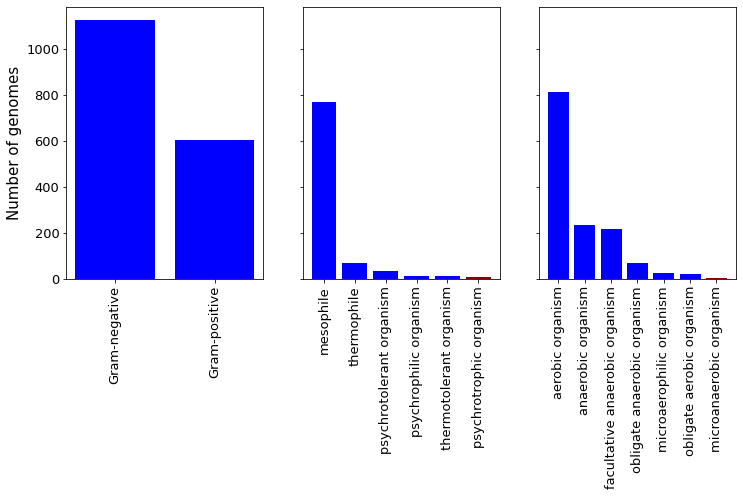

In [26]:
plt.style.use("seaborn-colorblind")
def plot_number_of_classes(files_path, min_freq=10):
  #files_d = [f for f in os.listdir(files_path) if f.endswith('count.csv')]
  gram = pd.read_csv("Gramstaining_count.csv")
  gram["color"] = gram["count"].apply(lambda x: "darkred" if x<=min_freq else "blue")
  temp = pd.read_csv("TempRange_count.csv")
  temp["color"] = temp["count"].apply(lambda x: "darkred" if x<=min_freq else "blue")
  oxy = pd.read_csv("OxygenReq_count.csv")
  oxy["color"] = oxy["count"].apply(lambda x: "darkred" if x<=min_freq else "blue")
  fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
  axs[0].bar(gram["phenotype"], gram["count"], color=gram["color"])
  axs[1].bar(temp["phenotype"], temp["count"], color=temp["color"])
  axs[2].bar(oxy["phenotype"], oxy["count"], color=oxy["color"])
  #fig.suptitle("Number of genomes per phenotype class")
  axs.flat[0].set_ylabel('Number of genomes', fontsize=15)
  for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90, fontsize=13)
    plt.yticks(fontsize=13)
  plt.savefig("a_num_classes.png", dpi=400, bbox_inches = "tight")
plot_number_of_classes("./")

######__Define global arguments__

In [26]:
genome_file = "genome_domain_architecture.csv"
pheno_file =  "OxygenReq.csv"  #  "Gramstaining.csv" # "TempRange.csv" # 
key_word = pheno_file.split(".")[0]
path_d = "./data"
delimiter=","
chunksize=10000
pheno_col="phenotype"
statistics=False
min_freq=10
n_splits=5
n_repeats=3
n_comp = 150
random_state = 26
test_size = 0.30
val_size = 0.10
models = get_models_to_be_evaluated()
mods = ["PLS", "LGB", "ANN"]
scoring = {"accuracy" : make_scorer(accuracy_score),
         "f1_score" : make_scorer(f1_score, average = "micro")}

params_log = {"solver": "lbfgs",
          "class_weight": "balanced",
          "C":4,
          "random_state": 26}

params_gbm = {"num_leaves": 70,
          "max_depth": 7,
          "objective": "multiclass",
          "num_class": 2,
          "learning_rate": 0.013,
          "metric": "multi_logloss",
          "boosting_type": "dart",
          "feature_fraction": 0.9,
          "bagging_fraction": 0.8,
          "bagging_freq": 5,
          "max_bin": 100,
          "num_iterations": 300}

params_svm = {"class_weight": "balanced",
          "max_iter": 10000,
          "tol": 1e-4,
          "C": 0.1,
          "random_state": 26
          }

params_xgb = {"max_depth": 6,
          "objective": "multi:softprob",
          "num_class": 2,
          "n_gpus": 0,
          "learning_rate": 0.7,
          "n_estimators": 1000,
          "max_delta_step": 5}

params_et = {"n_estimators": 1000, 
             "max_depth": 5,
             "class_weight": "balanced",
             "random_state": 26}

one_vs_rest = False
threshold = 0.5
limit = 1500

#####__Cross validation__

######__Load data for cross validation__

In [ ]:
data_frame, id_to_phenotype, phenotype_to_id, len_labeled, \
len_unlabeled, max_len = get_initial_data(genome_file, pheno_file, path_d,
                                          delimiter, chunksize, pheno_col,
                                          statistics, min_freq)

2020-11-27 23:11:49,399 : INFO : Parsing phenotype data...
2020-11-27 23:11:49,416 : INFO : Loading genomic data...
2020-11-27 23:11:49,529 : INFO : Merging phenotype and genomic data...
2020-11-27 23:11:58,316 : INFO : Working with chunk 1
2020-11-27 23:12:09,931 : INFO : Working with chunk 2
2020-11-27 23:12:26,984 : INFO : Working with chunk 3
2020-11-27 23:12:37,685 : INFO : Working with chunk 4
2020-11-27 23:12:49,534 : INFO : Working with chunk 5
2020-11-27 23:12:58,222 : INFO : Working with chunk 6
2020-11-27 23:13:06,584 : INFO : Working with chunk 7
2020-11-27 23:13:10,765 : INFO : Working with chunk 8
2020-11-27 23:13:15,236 : INFO : Working with chunk 9
2020-11-27 23:13:40,350 : INFO : Writing labeled and unlabeled data into separate CSV files
2020-11-27 23:15:54,869 : INFO : Removing lower frequency lower, min_freq=10...
2020-11-27 23:15:54,881 : INFO : Classes 5 were removed
2020-11-27 23:15:54,882 : INFO : 5 classes were kept


######__Retrieve features and labels and Vectorize genomes using TD-IDF__

In [ ]:
features = data_frame[' domain']
labels_dom = data_frame['phenotype_id'].to_numpy()
tfidf_vec = TfidfVectorizer(analyzer='word', max_df=0.8, norm='l2')
feature_trans = tfidf_vec.fit_transform(features).toarray()
class_weights = compute_class_weights(data_frame)
n_classes = len(np.unique(labels_dom))

######__Cross validation scores__

In [ ]:
cross_val = evaluate_models(features, labels_dom, models, scoring, 
                            n_splits, n_repeats, random_state)

cv_data, avg_data = cross_val_pls_lgb_ann(mods, feature_trans,labels_dom,
                                          n_comp, n_splits, n_repeats, 
                                          random_state)

Combine all cross validation scores

In [ ]:
f1_and_model = cross_val[["model_name", "test_f1_score"]]
final_cross_val = f1_and_model.append(cv_data)
final_cross_val.to_csv(f"cross_val_{key_word}.csv", index=False)
final_cross_val.head()

######__Average cross validation scores__

In [ ]:
avg_cross_val = average_metrics_per_model(final_cross_val)

######__Plot the cross validation scores per method__

Before running this cell, the code should be runned for all the three phenotype data (Gram staining, oxygen requirement and temperature range) or the phenotypes files names should be adapted accordingly.

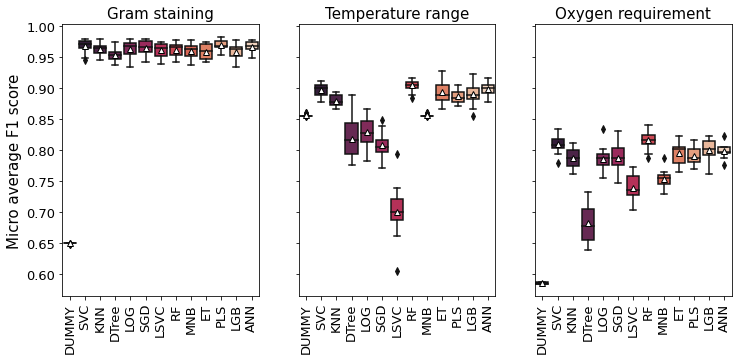

In [ ]:
gram = pd.read_csv("cross_val_Gramstaining.csv")
temp = pd.read_csv("cross_val_TempRange.csv")
oxy = pd.read_csv("cross_val_OxygenReq.csv")

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
#fig.suptitle('Micro average F1 score of the ML classifiers per phenotype dataset', size=15)

# Gram staining
sns.boxplot(ax=axes[0], data=gram, x="model_name", y="test_f1_score", palette="rocket",
            showmeans=True,
            meanprops={"markerfacecolor":"white",
                       "markeredgecolor":"black"})
axes[0].set_title("Gram staining", fontsize=15)

# Temp range
sns.boxplot(ax=axes[1], data=temp, x="model_name", y="test_f1_score", palette="rocket",
            showmeans=True,
            meanprops={"markerfacecolor":"white",
                       "markeredgecolor":"black"})
axes[1].set_title("Temperature range", fontsize=15)

# Oxygen requirement
sns.boxplot(ax=axes[2], data=oxy, x="model_name", y="test_f1_score", palette="rocket",
            showmeans=True,
            meanprops={"markerfacecolor":"white",
                       "markeredgecolor":"black"})
axes[2].set_title("Oxygen requirement", fontsize=15)

i=0
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90, fontsize=13)
    if i == 0:
      plt.yticks(fontsize=13)
      i += 1
axes.flat[0].set_xlabel(None, fontsize=15)
axes.flat[0].set_ylabel("Micro average F1 score", fontsize=15)

axes.flat[1].set_xlabel(None, fontsize=15)
axes.flat[1].set_ylabel(None, fontsize=15)

axes.flat[2].set_xlabel(None, fontsize=15)
axes.flat[2].set_ylabel(None, fontsize=15)

plt.savefig('Avg_cross_val.png', dpi=400, bbox_inches = "tight")

#####__Training and testing the model to check class specific F1 scores__

######__Split data into training and testing data sets__

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_dom, 
                                                    test_size=test_size,
                                                    stratify=labels_dom,
                                                    random_state=random_state)

######__Compute classes and sample weights__

In [ ]:
class_weights = compute_class_weights(data_frame)
sample_weight = get_array_of_class_weight_per_sample(class_weights, y_train)

######__Transform genome with TF-IDF into numeric vectors__

In [ ]:
tfidf_vec = TfidfVectorizer(analyzer='word', max_df=0.8, norm='l2')
X_train = tfidf_vec.fit_transform(X_train).toarray()
X_test = tfidf_vec.transform(X_test).toarray()
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)

######__Check classification report for each model__

In [ ]:
mod_fit = ExtraTreesClassifier(n_estimators=1000, max_depth=5,
                                      class_weight="balanced",random_state=26)
mod_fit2 = OneVsRestClassifier(LinearSVC(loss="hinge", C=0.1, random_state=26, class_weight="balanced", max_iter=10000, tol=1e-4))
g = fit_and_save_logistic_reg(X_train, y_train, params_log, one_vs_rest=False)
pred_mod = mod_fit.fit(X_train, y_train)

In [ ]:
pred = pred_mod.predict_proba(X_test)
labs = [id_to_phenotype[i] for i in data_frame["phenotype_id"].unique()]      
#print_stats(pred, y_test, labs)
pred

array([[0.13835694, 0.39130819, 0.25330822, 0.14019016, 0.07683649],
       [0.45520441, 0.27983427, 0.13993461, 0.05067781, 0.07434891],
       [0.19518938, 0.31514253, 0.27613263, 0.12997141, 0.08356405],
       ...,
       [0.14185555, 0.28728184, 0.28968887, 0.16111138, 0.12006235],
       [0.15860502, 0.38179596, 0.24579148, 0.12495409, 0.08885345],
       [0.09102642, 0.28799071, 0.18660373, 0.39931593, 0.03506321]])

Accuracy = 0.689
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        21
           1       0.97      0.69      0.81       231
           2       0.08      0.30      0.13        10
           3       0.14      0.75      0.24         4
           4       0.12      0.25      0.17         4

    accuracy                           0.69       270
   macro avg       0.36      0.58      0.39       270
weighted avg       0.87      0.69      0.75       270

--------------------------------------------------------------------------------
Confusion matrix


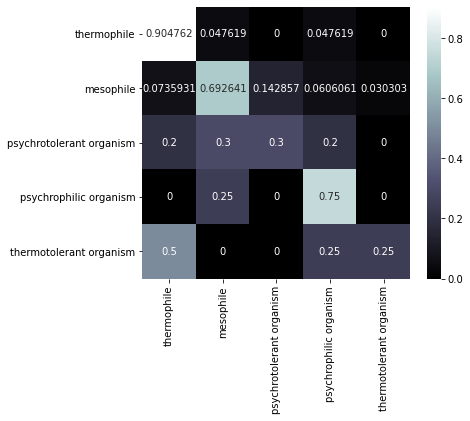

In [ ]:

p = np.array(pred_mod.decision_function(X_test)) # decision is a voting function
#prob = np.exp(p)/np.sum(np.exp(p),axis=1) # softmax after the voting
#np.exp(p)/np.sum(np.exp(p), axis=1)
#np.amax(softmax(p, axis=1), axis=1)
pred = softmax(p, axis=1)
pred = pred_mod.predict(X_test)
labs = [id_to_phenotype[i] for i in data_frame["phenotype_id"].unique()]      
print_stats(pred, y_test, labs)

****************** Classification for DummyClassifier---------------------
Accuracy = 0.856
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.86      1.00      0.92       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4

    accuracy                           0.86       270
   macro avg       0.17      0.20      0.18       270
weighted avg       0.73      0.86      0.79       270

--------------------------------------------------------------------------------
Confusion matrix


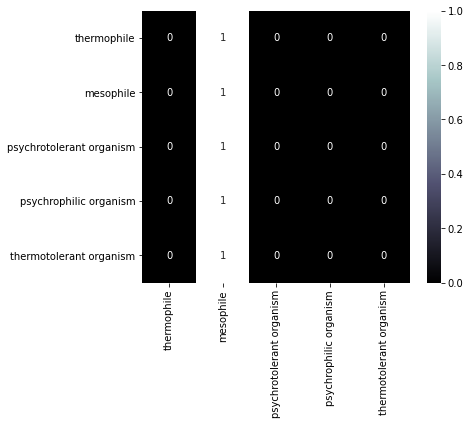

****************** Classification for SVC---------------------
Accuracy = 0.896
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.92      0.97      0.95       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.50      0.25      0.33         4

    accuracy                           0.90       270
   macro avg       0.44      0.40      0.41       270
weighted avg       0.86      0.90      0.87       270

--------------------------------------------------------------------------------
Confusion matrix


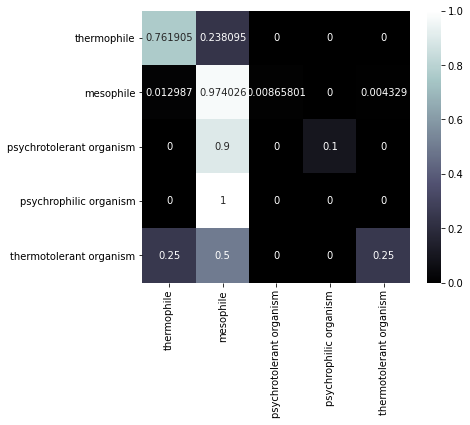

****************** Classification for KNeighborsClassifier---------------------
Accuracy = 0.878
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        21
           1       0.91      0.96      0.93       231
           2       0.00      0.00      0.00        10
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         4

    accuracy                           0.88       270
   macro avg       0.38      0.38      0.38       270
weighted avg       0.84      0.88      0.86       270

--------------------------------------------------------------------------------
Confusion matrix


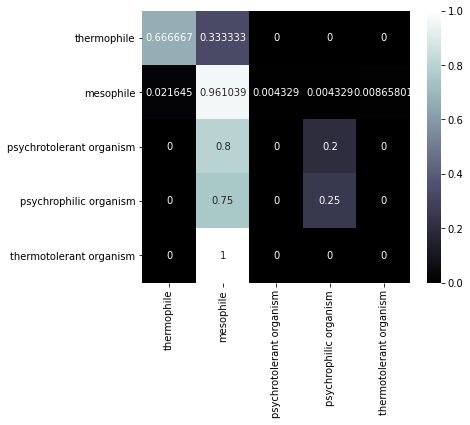

****************** Classification for DecisionTreeClassifier---------------------
Accuracy = 0.678
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52        21
           1       0.89      0.74      0.81       231
           2       0.02      0.10      0.03        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4

    accuracy                           0.68       270
   macro avg       0.29      0.27      0.27       270
weighted avg       0.80      0.68      0.73       270

--------------------------------------------------------------------------------
Confusion matrix


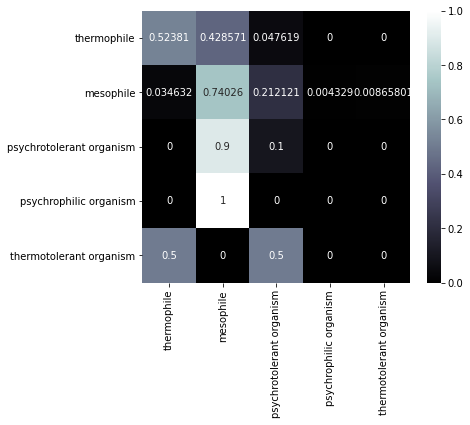

****************** Classification for LogisticRegression---------------------
Accuracy = 0.830
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        21
           1       0.95      0.87      0.91       231
           2       0.07      0.10      0.08        10
           3       0.18      0.50      0.27         4
           4       0.14      0.25      0.18         4

    accuracy                           0.83       270
   macro avg       0.41      0.52      0.45       270
weighted avg       0.88      0.83      0.85       270

--------------------------------------------------------------------------------
Confusion matrix


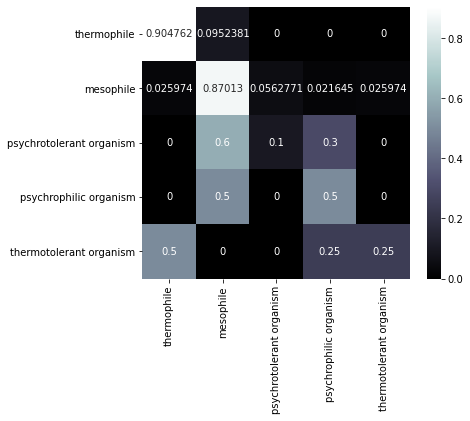

****************** Classification for SGDClassifier---------------------
Accuracy = 0.904
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.92      0.98      0.95       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.33      0.25      0.29         4

    accuracy                           0.90       270
   macro avg       0.43      0.41      0.42       270
weighted avg       0.86      0.90      0.88       270

--------------------------------------------------------------------------------
Confusion matrix


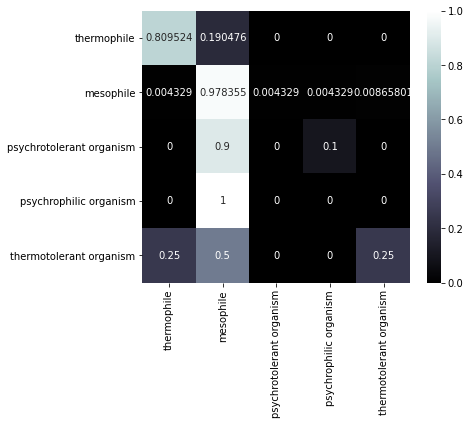

****************** Classification for LinearSVC---------------------
Accuracy = 0.856
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.86      1.00      0.92       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4

    accuracy                           0.86       270
   macro avg       0.17      0.20      0.18       270
weighted avg       0.73      0.86      0.79       270

--------------------------------------------------------------------------------
Confusion matrix


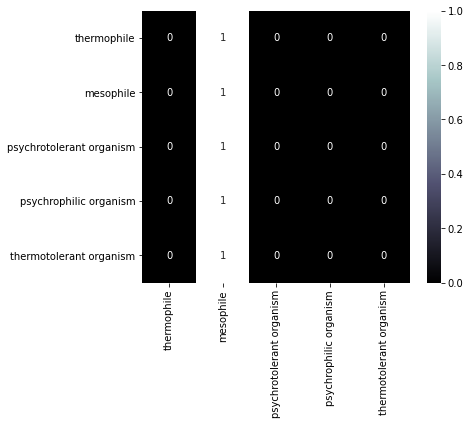

****************** Classification for RandomForestClassifier---------------------
Accuracy = 0.904
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.91      0.98      0.95       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       1.00      0.25      0.40         4

    accuracy                           0.90       270
   macro avg       0.54      0.40      0.43       270
weighted avg       0.86      0.90      0.88       270

--------------------------------------------------------------------------------
Confusion matrix


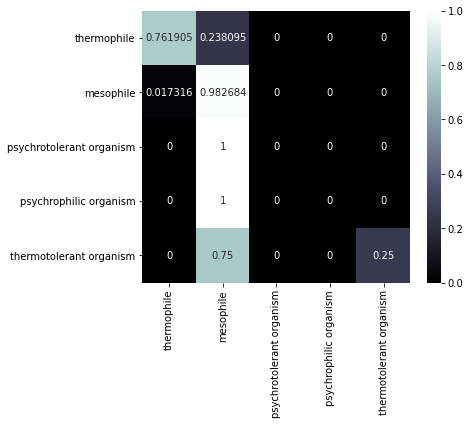

****************** Classification for MultinomialNB---------------------
Accuracy = 0.856
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.86      1.00      0.92       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4

    accuracy                           0.86       270
   macro avg       0.17      0.20      0.18       270
weighted avg       0.73      0.86      0.79       270

--------------------------------------------------------------------------------
Confusion matrix


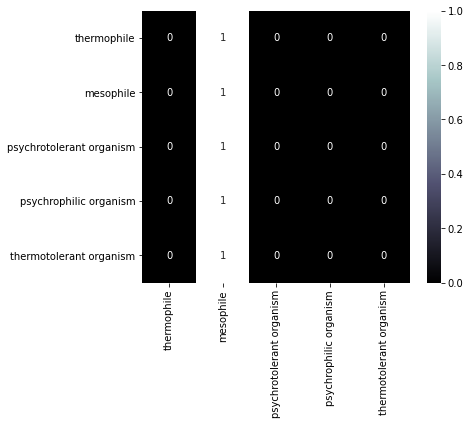

****************** Classification for ExtraTreesClassifier---------------------
Accuracy = 0.815
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.51      0.90      0.66        21
           1       0.95      0.85      0.90       231
           2       0.07      0.10      0.08        10
           3       0.22      0.50      0.31         4
           4       0.50      0.25      0.33         4

    accuracy                           0.81       270
   macro avg       0.45      0.52      0.46       270
weighted avg       0.87      0.81      0.83       270

--------------------------------------------------------------------------------
Confusion matrix


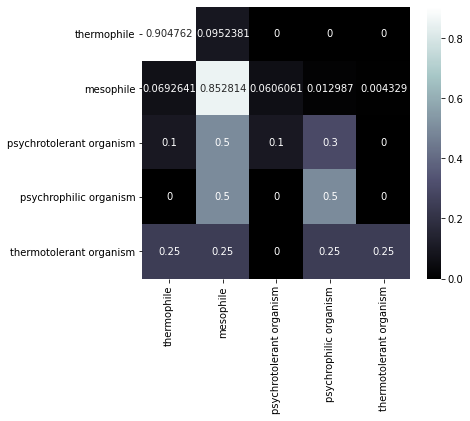

****************** Classification for PLSRegression---------------------
Accuracy = 0.904
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        21
           1       0.91      0.99      0.95       231
           2       0.50      0.10      0.17        10
           3       0.00      0.00      0.00         4
           4       1.00      0.25      0.40         4

    accuracy                           0.90       270
   macro avg       0.66      0.40      0.45       270
weighted avg       0.88      0.90      0.88       270

--------------------------------------------------------------------------------
Confusion matrix


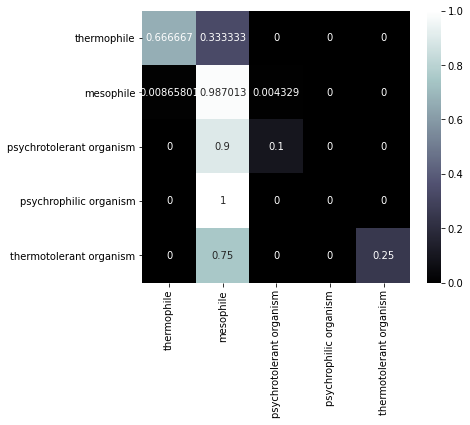

****************** Classification for module---------------------
Accuracy = 0.896
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.93      0.97      0.94       231
           2       0.33      0.10      0.15        10
           3       0.00      0.00      0.00         4
           4       0.50      0.25      0.33         4

    accuracy                           0.90       270
   macro avg       0.51      0.42      0.44       270
weighted avg       0.87      0.90      0.88       270

--------------------------------------------------------------------------------
Confusion matrix


****************** Classification for NoneType---------------------
Epoch 00148: early stopping
Accuracy = 0.878
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.33      0.48        21
           1       0.88      1.00      0.93       231
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4

    accuracy                           0.88       270
   macro avg       0.35      0.27      0.28       270
weighted avg       0.82      0.88      0.84       270

--------------------------------------------------------------------------------
Confusion matrix


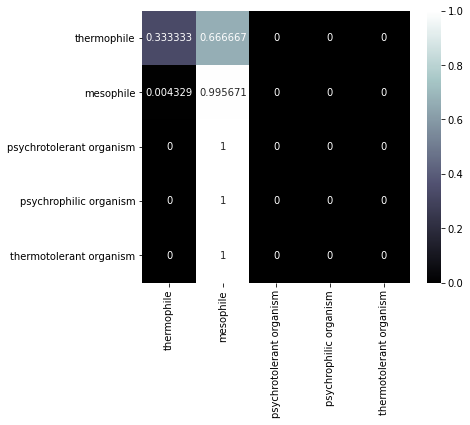

In [ ]:
models.update({"PLS": PLSRegression(n_comp), "LGB": lgb, "ANN": None})
for model in models:
  print(f"****************** Classification for {models[model].__class__.__name__}---------------------")
  if model not in ["PLS", "LGB", "ANN"]:
    mod = models[model].fit(X_train, y_train)
    pred = mod.predict(X_test)
  elif model == "PLS":
    mod = models[model].fit(X_train, y_train_cat)
    pred = np.argmax(mod.predict(X_test), axis=1)
  elif model == "LGB":
    mod = fit_lightgbm_model(X_train, y_train,
                             len(data_frame["phenotype_id"].unique()),
                             params=params_gbm,
                             weight=sample_weight,
                             save_as="good_LGB.model", 
                             save=False, epochs=50)
    pred = np.argmax(mod.predict(X_test), axis=1)
  else:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=val_size,
                                                stratify=y_train, 
                                                random_state=random_state)
    y_train_cat, y_val_cat = to_categorical(y_train), to_categorical(y_val)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min',
                         verbose=0, save_best_only=True)
    mod = nn_model((X_train.shape[1],), n_classes, "relu", hidden_units=100)

    if n_classes == 2:
      mod.fit(X_train, y_train, epochs=10000, batch_size=100, 
      validation_data=(X_val, y_val), verbose=0, callbacks=[es, mc])
      pred = np.round(mod.predict(X_test))
    else:
      mod.fit(X_train, y_train_cat, epochs=10000, batch_size=100, 
      validation_data=(X_val, y_val_cat), verbose=0, callbacks=[es, mc])
      pred = mod.predict_classes(X_test)
  labs = [id_to_phenotype[i] for i in data_frame["phenotype_id"].unique()]      
  print_stats(pred, y_test, labs)

#####__Run tri-training workflow__ 

######__Run the workflow for labeling__

In [27]:
tri_training_pipeline(genome_file, pheno_file, delimiter, chunksize,
                           pheno_col, key_word, statistics,
                           min_freq, params_log, params_et, params_gbm, 
                           one_vs_rest, path_d, threshold, limit, iteration=1)

2020-12-07 06:51:47,294 : INFO : **************** Iteraction 1****************
2020-12-07 06:51:47,296 : INFO : LOADING PHENOTYPE AND GENOME DATA FROM FILES...
2020-12-07 06:51:47,298 : INFO : Parsing phenotype data...
2020-12-07 06:51:47,349 : INFO : Loading genomic data...
2020-12-07 06:51:47,383 : INFO : Merging phenotype and genomic data...
2020-12-07 06:51:59,244 : INFO : Working with chunk 1
2020-12-07 06:52:10,967 : INFO : Working with chunk 2
2020-12-07 06:52:24,702 : INFO : Working with chunk 3
2020-12-07 06:52:32,345 : INFO : Working with chunk 4
2020-12-07 06:52:41,521 : INFO : Working with chunk 5
2020-12-07 06:52:47,339 : INFO : Working with chunk 6
2020-12-07 06:52:54,819 : INFO : Working with chunk 7
2020-12-07 06:52:58,985 : INFO : Working with chunk 8
2020-12-07 06:53:03,327 : INFO : Working with chunk 9
2020-12-07 06:53:28,369 : INFO : NumExpr defaulting to 4 threads.
2020-12-07 06:53:28,446 : INFO : Writing labeled and unlabeled data into separate CSV files
2020-12-0

LOG:                precision    recall  f1-score   support

           0       0.90      0.79      0.84       244
           1       0.73      0.68      0.70        71
           2       0.51      0.69      0.59        65
           3       0.06      0.14      0.09         7
           4       0.67      0.50      0.57         8
           5       0.50      0.62      0.55        21

    accuracy                           0.73       416
   macro avg       0.56      0.57      0.56       416
weighted avg       0.77      0.73      0.74       416

SVM:                precision    recall  f1-score   support

           0       0.88      0.82      0.85       244
           1       0.73      0.73      0.73        71
           2       0.54      0.68      0.60        65
           3       0.09      0.14      0.11         7
           4       1.00      0.50      0.67         8
           5       0.55      0.57      0.56        21

    accuracy                           0.75       416
   macro av

2020-12-07 06:57:03,714 : INFO : Loading chunk 1 ...
2020-12-07 06:57:33,758 : INFO : Loading chunk 2 ...
2020-12-07 06:58:12,876 : INFO : Loading chunk 3 ...
2020-12-07 06:58:53,205 : INFO : Loading chunk 4 ...
2020-12-07 06:59:37,277 : INFO : Loading chunk 5 ...
2020-12-07 07:00:20,403 : INFO : Loading chunk 6 ...
2020-12-07 07:01:09,235 : INFO : Loading chunk 7 ...
2020-12-07 07:01:41,981 : INFO : Loading chunk 8 ...
2020-12-07 07:02:08,852 : INFO : Loading chunk 9 ...
2020-12-07 07:02:44,333 : INFO : Loading chunk 10 ...
2020-12-07 07:03:07,560 : INFO : Loading chunk 11 ...
2020-12-07 07:03:31,928 : INFO : Loading chunk 12 ...
2020-12-07 07:03:57,251 : INFO : Loading chunk 13 ...
2020-12-07 07:04:28,667 : INFO : Loading chunk 14 ...
2020-12-07 07:04:53,262 : INFO : Loading chunk 15 ...
2020-12-07 07:05:05,899 : INFO : Loading chunk 16 ...
2020-12-07 07:05:32,340 : INFO : Loading chunk 17 ...
2020-12-07 07:05:56,655 : INFO : Done successfully with iteration 1
2020-12-07 07:05:56,796

LOG:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      6181
           1       0.98      0.98      0.98      1245
           2       1.00      0.99      1.00     10169
           3       0.85      0.91      0.88        55
           4       0.99      0.99      0.99       443
           5       0.96      0.97      0.96       388

    accuracy                           0.99     18481
   macro avg       0.96      0.97      0.97     18481
weighted avg       0.99      0.99      0.99     18481

SVM:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      6181
           1       0.97      0.98      0.97      1245
           2       1.00      0.99      1.00     10169
           3       0.94      0.89      0.92        55
           4       1.00      0.98      0.99       443
           5       0.94      0.96      0.95       388

    accuracy                           0.99     18481
   macro av

2020-12-07 07:25:56,007 : INFO : LABELLING UNLABELED DATA...


XGB:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      6181
           1       0.96      0.96      0.96      1245
           2       1.00      0.99      1.00     10169
           3       0.96      0.91      0.93        55
           4       1.00      0.98      0.99       443
           5       0.90      0.96      0.93       388

    accuracy                           0.99     18481
   macro avg       0.97      0.97      0.97     18481
weighted avg       0.99      0.99      0.99     18481



2020-12-07 07:25:58,171 : INFO : Loading chunk 1 ...
2020-12-07 07:26:20,739 : INFO : Loading chunk 2 ...
2020-12-07 07:26:44,338 : INFO : Loading chunk 3 ...
2020-12-07 07:27:08,796 : INFO : Loading chunk 4 ...
2020-12-07 07:27:24,111 : INFO : Loading chunk 5 ...
2020-12-07 07:27:41,548 : INFO : Done successfully with iteration 2
2020-12-07 07:27:42,913 : INFO : **************** Iteraction 3****************
2020-12-07 07:27:42,914 : INFO : LOADING PHENOTYPE AND GENOME DATA FROM FILES...
2020-12-07 07:27:42,916 : INFO : Loading data from existing file...
2020-12-07 07:27:46,247 : INFO : Loading chunk 1 ...
2020-12-07 07:27:50,178 : INFO : Loading chunk 2 ...
2020-12-07 07:27:54,500 : INFO : Loading chunk 3 ...
2020-12-07 07:27:59,018 : INFO : Loading chunk 4 ...
2020-12-07 07:28:03,571 : INFO : Loading chunk 5 ...
2020-12-07 07:28:08,832 : INFO : Loading chunk 6 ...
2020-12-07 07:28:11,735 : INFO : Loading chunk 7 ...
2020-12-07 07:28:15,735 : INFO : Loading chunk 8 ...
2020-12-07 07:2

LOG:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      8080
           1       0.98      0.99      0.98      2659
           2       1.00      0.99      1.00     11864
           3       0.87      0.95      0.91        62
           4       0.99      0.99      0.99       512
           5       0.95      0.99      0.97       661

    accuracy                           0.99     23838
   macro avg       0.96      0.98      0.97     23838
weighted avg       0.99      0.99      0.99     23838

SVM:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      8080
           1       0.98      0.98      0.98      2659
           2       1.00      0.99      1.00     11864
           3       0.95      0.94      0.94        62
           4       0.99      0.98      0.99       512
           5       0.94      0.98      0.96       661

    accuracy                           0.99     23838
   macro av

2020-12-07 07:53:35,757 : INFO : LABELLING UNLABELED DATA...


XGB:                precision    recall  f1-score   support

           0       0.99      0.99      0.99      8080
           1       0.95      0.98      0.97      2659
           2       1.00      0.99      0.99     11864
           3       0.95      0.94      0.94        62
           4       0.99      0.98      0.99       512
           5       0.94      0.98      0.96       661

    accuracy                           0.99     23838
   macro avg       0.97      0.98      0.97     23838
weighted avg       0.99      0.99      0.99     23838



2020-12-07 07:53:37,781 : INFO : Loading chunk 1 ...
2020-12-07 07:53:55,931 : INFO : Done successfully with iteration 3
2020-12-07 07:53:57,807 : INFO : Stop labelling with undadded = 948


######__Train and test the workflow models on the finally labeled data__

Load the finally labeled data

In [ ]:
data = pd.read_csv(f"{path_d}/labeled_data.csv")
data = remove_classes_with_low_freq(data, min_freq) # remove infrequent classes

2020-11-28 22:05:35,119 : INFO : Classes 5 were removed
2020-11-28 22:05:35,120 : INFO : 5 classes were kept


Retrieve features and labels and split them into training and testing sets

In [ ]:
domains = data[" domain"] # Features
phenotypes = data["phenotype_id"] # phenotype labels

# split into training and testing data
x_train, x_test, y_train, y_test = train_test_split(domains, phenotypes, 
                                                    test_size=test_size,
                                                    stratify=phenotypes,
                                                    random_state=random_state)

In [ ]:
del  domains, data

Calculate sample and class weights

In [ ]:
c_weights = compute_class_weights(data)
s_weights = get_array_of_class_weight_per_sample(c_weights, y_train)

Transformdata in vectors using TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', max_df=0.8, norm='l2')

x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

In [ ]:
x_test = vectorizer.transform(x_test).toarray()

Train

In [ ]:
logging.info(f"Fitting Logistic Regression model...")
file_name = f"{path_d}/log_model_{key_word}_final.joblib"
log_mod = fit_and_save_logistic_reg(x_train, y_train, params_log, one_vs_rest,
                                    save=True, save_as=file_name)
  
logging.info(f"Fitting Support Vector Machine model...")
file_name = f"{path_d}/svm_model_{key_word}_final.joblib"
svm_mod = fit_and_save_svm(x_train, y_train, params_svm, save=True,
                           save_as=file_name)

logging.info(f"Fitting LightXGB model...")
num_class = len(y_train.unique())
file_name = f"{path_d}/lgb_model_{key_word}_final.model"
xgb_mod = fit_lightgbm_model(x_train, y_train, num_class, params_gbm,
                             weight=s_weights, save=True,
                             save_as=file_name, epochs=50)

del x_train, y_train

2020-11-28 22:25:34,414 : INFO : Fitting Logistic Regression model...
2020-11-28 22:28:53,966 : INFO : Fitting Support Vector Machine model...
2020-11-28 22:29:39,739 : INFO : Fitting LightXGB model...


Print stats of the workflow performance metrics

In [ ]:
log_pred = log_mod.predict(x_test)

svm_pred = svm_mod.predict(x_test)

xgb_pred = np.argmax(xgb_mod.predict(x_test), axis=1)

del x_test

Accuracy = 0.982
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       497
           1       1.00      0.98      0.99     23496
           2       0.69      0.98      0.81       288
           3       0.64      1.00      0.78       188
           4       0.96      1.00      0.98       548

    accuracy                           0.98     25017
   macro avg       0.80      0.99      0.88     25017
weighted avg       0.99      0.98      0.98     25017

--------------------------------------------------------------------------------
Confusion matrix


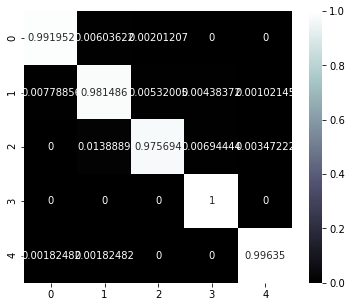

Accuracy = 0.978
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       497
           1       1.00      0.98      0.99     23496
           2       0.65      0.98      0.78       288
           3       0.62      0.97      0.76       188
           4       0.94      0.99      0.97       548

    accuracy                           0.98     25017
   macro avg       0.78      0.98      0.86     25017
weighted avg       0.98      0.98      0.98     25017

--------------------------------------------------------------------------------
Confusion matrix


Accuracy = 0.958
--------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.47      0.96      0.63       497
           1       1.00      0.96      0.98     23496
           2       0.48      0.95      0.64       288
           3       0.60      0.99      0.75       188
           4       0.89      0.99      0.94       548

    accuracy                           0.96     25017
   macro avg       0.69      0.97      0.79     25017
weighted avg       0.98      0.96      0.96     25017

--------------------------------------------------------------------------------
Confusion matrix


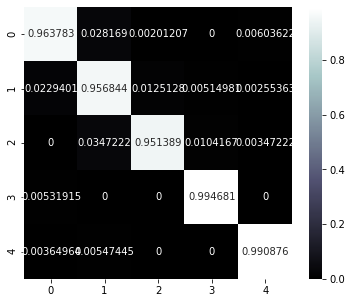

In [ ]:
preds = [log_pred, svm_pred, xgb_pred] # list of all the predictions
labs = list(phenotypes.unique())# class labels

for pred in preds:
  print_stats(pred, y_test, labs)

####__load only data__

In [ ]:
get_initial_data(genome_file, pheno_file, path_d)